<a href="https://colab.research.google.com/github/phytometrics/plant_phenotyping_python/blob/main/notebooks/plantseg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PlantSegを用いた染色画像の細胞インスタンス・セグメンテーション

<img src="https://cdn.jsdelivr.net/gh/phytometrics/plant_phenotyping_python@main/assets/d9e2211b9f7ee3748313c79760ec852913449e62850677539cca9e381e1e9c09.png" alt="Image" style="background-color: white;">
plantsegの公式レポジトリより転載<sup>1</sup>

## 解説
植物の細胞壁をなんらかの試薬で染色、もしくは蛍光タンパク質で光らせ、共焦点顕微鏡で撮影する状況があるとします。どんなに染色条件や顕微鏡の撮影条件を検討しても、染色ムラや光の散乱や減衰、さらには屈折率の不均一性などの理由で、均一に細胞壁を検出した画像を取得することは大変難しいことかと思います。もし均一に取ることができれば１視野にある無数の細胞の形を自動計測し、遺伝子の機能解析や発生モデルの構築などに役立てられるのに、現実はそうではなく、大変な補正作業が入ることが多いですね。

PlantSeg<sup>2</sup>は、共焦点顕微鏡やライトシート顕微鏡を用いて取得された3Dボリューム画像（2Dも可能です）における細胞インスタンスの認識を可能にするツールです​​。このツールは、主に植物細胞組織の染色画像に対してチューニングされており、訓練済みのモデルも提供されています​。

PlantSegは、2つのステップから構成されています​。

1. 細胞境界の予測：2D/3D U-Netを用い、細胞の境界領域を検出・抽出します。具体的には自家蛍光や染色由来のシグナル強度を均一化し、細胞壁の欠落やぼやけなど）を修正することができます​。
2. 細胞セグメンテーション：４種類の領域分割アルゴリズムが実装されています。
    - Multicut
    - GASP average
    - Mutex watershed
    - Distance transform watershed

PlantSegの出力フォーマットはHierarchical Data Format (HDF5)またはTagged Image File Format (TIFF)であり、本ソフトを前処理として活用した後、ilastik、MorphographX、Fijiといったよく使われる画像解析ソフトで引き続き解析を行うことも可能です。

## 環境構築

In [1]:
#このセルを実行するとcolabが再起動（セッションがクラッシュしたと表示）しますが正常な動作です。
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.1.0-1/Mambaforge-23.1.0-1-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:13
🔁 Restarting kernel...


In [2]:
# this code will take time. grab some coffee and wait.

# 公式の環境設定はanacondaとmambaを利用しますので、それに準拠します。
!conda install -q -c conda-forge mamba
!mamba install -q -c pytorch -c nvidia -c conda-forge -c lcerrone plantseg pytorch-cuda=11.7

#　可視化ライブラリもあわせてインストールします。
!pip -q install itk PyYAML imjoy-elfinder 'itkwidgets>=1.0a23'

Solving environment: ...working... done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - mamba


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    boltons-23.0.0             |     pyhd8ed1ab_0         296 KB  conda-forge
    ca-certificates-2023.5.7   |       hbcca054_0         145 KB  conda-forge
    certifi-2023.5.7           |     pyhd8ed1ab_0         149 KB  conda-forge
    conda-23.3.1               |  py310hff52083_0         941 KB  conda-forge
    jsonpatch-1.32             |     pyhd8ed1ab_0          14 KB  conda-forge
    jsonpointer-2.0            |             py_0           9 KB  conda-forge
    openssl-3.1.1              |       hd590300_1         2.5 MB  conda-forge
    packaging-23.1             |     pyhd8ed1ab_0          45 KB  conda-forge
    ------------------------------------------------------------
                               

## 解析対象データのダウンロードと確認
PlantSegを作成するために使われたtrain/validation/test datasetはOSF Homeにてホスティングされています<sup>3</sup>。ここからテストデータに使われた"3D confocal images of fixed *Arabidopsis thaliana* ovules"の１つをダウンロードします。

In [5]:
file_name = "N_294_final_crop_ds2.h5"
!wget -O {file_name} https://osf.io/nk9em/download

In [6]:
# どのようなデータか可視化してみましょう
import h5py

raw_data = {}
with h5py.File(file_name, 'r') as file:
    def get_data_as_dict(name, obj):
        raw_data[name] = file[name][:]
    file.visititems(get_data_as_dict)

In [3]:
separator = '-' * 20 # 出力整理用

# 取得したデータにはlabel, label_with_ignore, rawというデータが格納されています。
print(raw_data.keys())
print(separator)

# それぞれのデータ型を確認すると、numpy arrayであることがわかります。
for key, value in raw_data.items():
    print(key, type(value))
print(separator)

# さらにnumpy array sizeは320,960,1000、縦320px,横960px,Z軸方向1000枚であり、
# ラベル情報はuint16、撮影画像はuint8のdtypeであることが確認できます。

for key, value in raw_data.items():
    print(key, value.dtype, value.shape)


dict_keys(['label', 'label_with_ignore', 'raw'])
--------------------
label <class 'numpy.ndarray'>
label_with_ignore <class 'numpy.ndarray'>
raw <class 'numpy.ndarray'>
--------------------
label uint16 (320, 960, 1000)
label_with_ignore int16 (320, 960, 1000)
raw uint8 (320, 960, 1000)


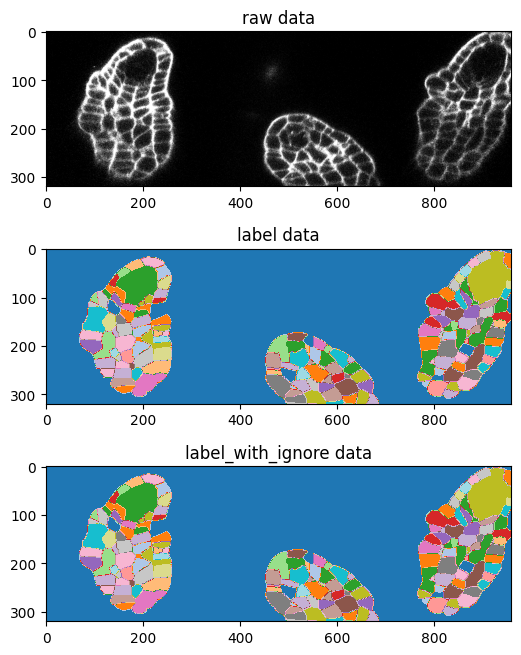

In [4]:
import matplotlib.pyplot as plt

# 100枚目の画像を表示してみます。
frame = 100

plt.figure(figsize=(6,8))

plt.subplot(3,1,1)
plt.title("raw data")
plt.imshow(raw_data["raw"][...,frame],cmap="gray")

plt.subplot(3,1,2)
plt.title("label data")
plt.imshow(raw_data["label"][...,frame],cmap="tab20")

plt.subplot(3,1,3)
plt.title("label_with_ignore data")
plt.imshow(raw_data["label_with_ignore"][...,frame],cmap="tab20")

plt.subplots_adjust()

## 解析


PlantSegはGUIを提供していますが、google colaboratoryでは使えないため、コマンドラインベースでの解析を行います。基本的な使い方として、必要な情報を全てyamlファイルに記述し、下記のように実行します。
```shell
plantseg --config config.yaml
```

公式レポジトリ<sup>1</sup>で提供されているexample yamlファイルを元に解析設定を定義しましょう。

In [5]:
# ColaboratoryのCPUのコア数を事前に調べます。
import multiprocessing
num_workers = multiprocessing.cpu_count()
print("Number of available workers:", num_workers)

Number of available workers: 12


In [6]:
import yaml

# 解析画像。hdf5形式またはmultitiffファイルを入力することができます。
INPUT_PATH = "/content/N_294_final_crop_ds2.h5"

data = {
    # Contains the path to the directory or file to process
    "path": INPUT_PATH,
    "preprocessing": {
        # enable/disable preprocessing
        "state": True,
        # create a new sub folder where all results will be stored
        "save_directory": "PreProcessing",
        # rescaling the volume is essential for the generalization of the networks. The rescaling factor can be computed as the resolution
        # of the volume at hand divided by the resolution of the dataset used in training. Be careful, if the difference is too large check for a different model.
        "factor": [1.0, 1.0, 1.0],
        # the order of the spline interpolation
        "order": 2,
        # cropping out areas of little interest can drastically improve the performance of plantseg.
        # crop volume has to be input using the numpy slicing convention [b_z:e_z, b_x:e_x, b_y:e_y], where b_zxy is the
        # first point of a bounding box and e_zxy is the second. eg: [:, 100:500, 400:900]
        "crop_volume": "[:,:,:]",
        # optional: perform Gaussian smoothing or median filtering on the input.
        "filter":{
            # enable/disable filtering
            "state": False,
            # Accepted values: 'gaussian'/'median'
            "type": "gaussian",
            # sigma (gaussian) or disc radius (median)
            "filter_param": 1.0
            }
        },
    "cnn_prediction":{
        # enable/disable UNet prediction
        "state": True,
        # Trained model name, more info on available models and custom models in the README
        "model_name": "generic_confocal_3D_unet",
        # If a CUDA capable gpu is available and corrected setup use "cuda", if not you can use "cpu" for cpu only inference (slower)
        "device": "cuda",
        # how many subprocesses to use for data loading
        # 上のコードセルで調べたworkerの数を上回らないようにしてください。
        "num_workers": 8,
        # patch size given to the network (adapt to fit in your GPU mem)
        "patch": [100, 160, 160],
        # stride between patcheswill be computed as `stride_ratio * patch`
        # recommended values are in range `[0.5, 0.75]` to make sure the patches have enough overlap to get smooth prediction maps
        "stride_ratio": 0.75,
        # If "True" forces downloading networks from the online repos
        "model_update": False,
        },

    "cnn_postprocessing":{
        # enable/disable cnn post processing
        "state": False,
        # if True convert to result to tiff
        "tiff": False,
        # rescaling factor
        "factor": [1, 1, 1],
        # spline order for rescaling
        "order": 2
    },

    "segmentation":{
        # enable/disable segmentation
        "state": True,
        # Name of the algorithm to use for inferences. Options: MultiCut, MutexWS, GASP, DtWatershed
        "name": "MultiCut",
        # Segmentation specific parameters here
        # balance under-/over-segmentation; 0 - aim for undersegmentation, 1 - aim for oversegmentation. (Not active for DtWatershed)
        "beta": 0.5,
        # directory where to save the results
        "save_directory": "MultiCut",
        # enable/disable watershed
        "run_ws": True,
        # use 2D instead of 3D watershed
        "ws_2D": True,
        # probability maps threshold
        "ws_threshold": 0.5,
        # set the minimum superpixels size
        "ws_minsize": 50,
        # sigma for the gaussian smoothing of the distance transform
        "ws_sigma": 2.0,
        # sigma for the gaussian smoothing of boundary
        "ws_w_sigma": 0,
        # set the minimum segment size in the final segmentation. (Not active for DtWatershed)
        "post_minsize": 50
        },
    "segmentation_postprocessing":{
        # enable/disable segmentation post processing
        "state": True,
        # if True convert to result to tiff
        "tiff": False,
        # rescaling factor
        "factor": [1, 1, 1],
        # spline order for rescaling (keep 0 for segmentation post processing
        "order": 0,
        # save raw input in the output segmentation file h5 file
        "save_raw": True
    }
}

with open('config.yaml', 'w') as file:
    yaml.dump(data, file)


## 推論

In [7]:
!plantseg --config config.yaml

2023-06-15 01:23:01,182 [MainThread] WARNING PlantSeg - key: 'patch_halo' is missing, plant-seg is trying to use a default.
2023-06-15 01:23:01,182 [MainThread] WARNING PlantSeg - key: patch_halo has got value: None, but value must be a list (or tuple). defaulting default value: [2, 4, 4]
2023-06-15 01:23:01,182 [MainThread] WARNING PlantSeg - key: 'output_type' is missing, plant-seg is trying to use a default.
2023-06-15 01:23:01,182 [MainThread] WARNING PlantSeg - key: output_type has got value: None, but value must be a string. defaulting default value: data_float32
2023-06-15 01:23:01,182 [MainThread] WARNING PlantSeg - key: 'save_raw' is missing, plant-seg is trying to use a default.
2023-06-15 01:23:01,182 [MainThread] WARNING PlantSeg - key: save_raw has got value: None, but value must be a bool. defaulting default value: False
2023-06-15 01:23:01,182 [MainThread] INFO PlantSeg - Running the pipeline on: ['/content/N_294_final_crop_ds2.h5']
2023-06-15 01:23:01,183 [MainThread] I

## 結果の確認

In [7]:
import matplotlib.pyplot as plt
import numpy as np

In [8]:
# どのようなデータが得られたか可視化してみましょう
# 入力データと同様にhdf5の構造を確認します。



file_path ="/content/PreProcessing/generic_confocal_3D_unet/N_294_final_crop_ds2_predictions.h5"

data = {}
with h5py.File(file_path, 'r') as file:
    def get_data_as_dict(name, obj):
        data[name] = file[name][:]
    file.visititems(get_data_as_dict)

separator = '-' * 20

print(data.keys())
print(separator)

for key, value in data.items():
    print(key, type(value))
print(separator)

for key, value in data.items():
    print(key, value.dtype, value.shape)


dict_keys(['predictions'])
--------------------
predictions <class 'numpy.ndarray'>
--------------------
predictions float32 (320, 960, 1000)


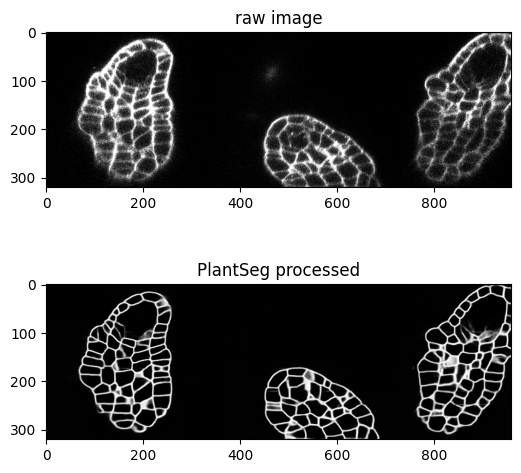

In [9]:
# 処理前と後を比べてみましょう
frame = 100
plt.figure(figsize=(6,6))
plt.subplot(2,1,1)
plt.title("raw image")
plt.imshow(raw_data["raw"][...,frame],cmap="gray")
plt.subplot(2,1,2)
plt.title("PlantSeg processed")
plt.imshow(data["predictions"][...,frame],cmap="gray")

## colaboratoryで三次元データ表示（おまけ）

itkwidgetsを利用することで三次元データをブラウザ内で可視化することができます。

In [10]:
import numpy as np
from skimage.transform import rescale
import itk
from itkwidgets import view

In [23]:
# multicutが適用されたsegmented dataも準備します。
path = "/content/PreProcessing/generic_confocal_3D_unet/MultiCut/N_294_final_crop_ds2_predictions_multicut.h5"
with h5py.File(path, 'r') as file:
    label_images = file["segmentation"][:]
print(label_images.shape)

(320, 960, 1000)


In [24]:
# PlantSeg適用後データ
images = data["predictions"]


# メモリとロード時間の節約、ブラウザの不可軽減のため、画像サイズを小さくします。
# scale = 1/16
# images = np.array([rescale(x, (scale, scale), order=0, preserve_range=True) for x in images])
# label_images = np.array([rescale(x, (scale, scale), order=0, preserve_range=True) for x in label_images])

# 処理後画像は0-1のrangeですので0-255のuint8型に変換します。
images *= 255.
images = images.astype(np.uint8)

# channel次元を足します。
# images = images[...,np.newaxis]
# label_images = label_images[...,np.newaxis]

In [25]:
print(images.shape, label_images.shape)

(320, 960, 1000) (320, 960, 1000)


ちなみにこのデータセットのボクセルサイズは*0.075 × 0.075 × 0.235 μm*ですので<sup>2</sup>、
Itk imageフォーマットに変換する際、メタデータを付与しましょう

In [26]:
import itk

# Convert the NumPy array to an ITK image
itk_image = itk.image_view_from_array(images)
itk_label_image =  itk.image_view_from_array(label_images)
# Define the voxel spacing. The values are in millimeters.
# You should replace 'x_spacing', 'y_spacing', and 'z_spacing'
# with the correct values for your image.
spacing = (1/0.075,1/0.075,1/0.235)
itk_image.SetSpacing(spacing)
itk_label_image.SetSpacing(spacing)


In [27]:
# 実行環境によっては動作が重たいかもしれません。その場合、完全にロードが終了するまで待機するか、他のソフトを用いてください。
view(image=itk_image, label_image=itk_label_image)

KeyboardInterrupt: ignored

## 引用文献

1. https://github.com/hci-unihd/plant-seg/
    - MIT License
2. Wolny, A. et al., (2020). Accurate and versatile 3D segmentation of plant tissues at cellular resolution. eLife, 9. https://doi.org/10.7554/eLife.57613

3. https://osf.io/uzq3w/

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
!cp -r /content/PreProcessing drive/MyDrive/PreProcessing/